# Jupyter Notebook for Hippocampal Navigation Modeling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.collections import LineCollection
import math

%matplotlib inline

Define the RingOscillator class: a collection of N cells defined by slope of speed sensivitiy, $\rho$, and directional tuning, $\theta$. The cells connect to each other in a ring formation (last cell wraps around to first). By changing the connection noise, we add variability to the timing of the connections between the cells (so that they are not perfectly evenly spaced).

## Class and Function Definitions

In [2]:
class RingOscillator:
        
    def __init__(self, N, rho, theta, phz_noise=0):
        self.rho = rho
        self.theta = theta
        self.phz_noise = phz_noise
        self.cellphz = self._add_noise(N, phz_noise)
    
    def __repr__(self):
        ret_s = 'RingOscillator[N={}, (rho, theta)=({}, {:f}), phi_n={}]'
        return ret_s.format(self.cellphz.shape[0], self.rho, self.theta,self.phz_noise)
    
    def _add_noise(self, N, phz_noise):
        cellphz = np.zeros(N)
        phz_int = 2.0 * np.pi / N
        valid = False
        while not valid:
            phase = 0
            for i in range(N):
                cellphz[i] = phase
                if (i==(N-1)):
                    if not((phase > 2*np.pi) or (phase < 2*(np.pi - phz_int))):
                        valid = True
                else:
                    noise = (2 * phz_int * (np.random.random() - 0.5)) * phz_noise
                    phase = phase + phz_int + noise
        return cellphz
    
    def _add_noise_N(self, N, phz_noise):
        cellphz = np.zeros(N)
        phz_int = 2.0 * np.pi / N
        phz_noise = phz_noise * phz_int
        if not phz_noise:
            return np.arange(0,2*np.pi,phz_int)
        valid = False
        while not valid:
            print("trying...")
            phase = 0
            for i in range(N):
                cellphz[i] = phase
                if (i==(N-1)):
                    if not((phase > 2*np.pi) or (phase < 2*(np.pi - phz_int))):
                        valid = True
                else:
                    noise = np.maximum(0,(np.random.randn() + phz_int) * phz_noise)
                    phase = phase + noise
        return cellphz
    
    def cell_activity(self, cell, path, F_bar=7):
        return F_bar + (self.rho * path[:,0])/(2 * np.pi)*np.cos(path[:,1] + self.cellphz[cell] - self.theta)
    
    def cell_activity_2(self, cell, xx, yy, F_bar=0):
        x_term = self.rho * np.cos(-self.theta) * xx
        y_term = self.rho * np.sin(-self.theta) * yy
        phz_term = self.cellphz[cell] + np.pi/2.0
        return F_bar + np.exp(1j * (x_term + y_term + phz_term));

    def cell_activity_3(self, cell, xx, yy, F_bar=0):
        x_term = self.rho * np.cos(-self.theta) * xx
        y_term = self.rho * np.sin(-self.theta) * yy
        phz_term = self.cellphz[cell] + np.pi/2.0
        return np.exp(1j * (np.cos(0) + np.sin(0))) + np.exp(1j * (x_term + y_term + phz_term));
    
    def ring_activity(self, path):
        activity = np.zeros([self.cellphz.shape[0], path.shape[0]])
        for cell in range(self.cellphz.shape[0]):
            activity[cell,:] = self.cell_activity(cell, path)
        return activity

In [3]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)

In [4]:
def randwalk(v=5, N=100, size=5):
    rwpath = np.ones([N,2]) * (size/2.)
    for step in np.arange(1,N):
        while (np.abs(rwpath[step,:])>=(size/2.)).any():
            vel = np.random.random()/v
            theta=2*math.pi*np.random.random()
            dx = vel*math.cos(theta)
            dy = vel*math.sin(theta)
            rwpath[step,:] = rwpath[step-1,:] + [dx, dy]
        
    return rwpath

In [5]:
def plot_weights(weights):
    # Plot weights matrix
    (y_size, x_size) = weights.shape
    plt.figure()#figsize=(10,10))
    im = plt.imshow(weights,cmap='jet',origin='lower')
    ax = plt.gca()
    plt.title('Weights Matrix')
    ax.grid(which='both', color='lightgray', linestyle='-', linewidth=2)
    ax.set_xticks(np.arange(-0.5,x_size,1))
    ax.set_yticks(np.arange(-0.5,y_size,1))
    ax.set_xticklabels(np.arange(0, 12, 1))
    ax.set_yticklabels(np.arange(0, 6, 1))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.25)
    plt.colorbar(im, cax=cax)

In [6]:
def plot_randwalk(path, E_sum, arena=(5,5)):
    x   = path[:,0] 
    y   = path[:,1]

    E_sum = abs(E_sum)
    E_max = np.max(E_sum)
    E_thresh = E_sum - 0.65*E_max
    E_thresh[E_thresh<0] = 0
    E_max  = np.max(E_thresh)
    E_norm = E_thresh/E_max

    # set up a list of (x,y) points
    points = np.array([x,y]).transpose().reshape(-1,1,2)
    print(points.shape)  # Out: (len(x),1,2)

    # set up a list of segments
    segs = np.concatenate([points[:-1],points[1:]],axis=1)
    print(segs.shape)  # Out: ( len(x)-1, 2, 2 )
                      # see what we've done here -- we've mapped our (x,y)
                      # points to an array of segment start/end coordinates.
                      # segs[i,0,:] == segs[i-1,1,:]

    # make the collection of segments
    lc = LineCollection(segs, cmap=plt.get_cmap('jet'))
    lc.set_array(E_norm) # color the segments by our parameter

    # plot the collection
    plt.figure(figsize=(10,10))
    plt.gca().add_collection(lc) # add the collection to the plot
    plt.xlim(-arena[0], arena[0]) # line collections don't auto-scale the plot
    plt.ylim(-arena[1], arena[1])

In [7]:
def hcn_activity(matrix, weights, size):
    # Create mesh grid to tile space of [[-size, size],[-size, size]]
    ss = np.linspace(-size,size,10*size)
    xx, yy = np.meshgrid(ss,ss)
    
    # Find sum of responses from all cells in weights matrix
    response_sum = np.zeros([10*size,10*size],dtype='complex128')
    for row in range(weights.shape[0]):
        for col in range(weights.shape[1]):
            if not np.isnan(weights[row,col]):
                cell_response = matrix[row][col].cell_activity_2(int(weights[row,col]), xx, yy)
                response_sum = response_sum + cell_response

    response_sum = abs(response_sum)
    max_response = np.max(response_sum)
    thresh = response_sum - 0.65*max_response
    thresh[thresh<0] = 0
    max_response = np.max(thresh)
    response_norm = thresh / max_response
    return response_norm, response_sum


In [8]:
def theta_to_grid(matrix, weights, size):
    # Create mesh grid to tile space of [[-size, size],[-size, size]]
    ss = np.linspace(-size,size,10*size)
    xx, yy = np.meshgrid(ss,ss)
    
    # Find product of responses from all cells in weights matrix
    response_product = np.ones([10*size,10*size],dtype='complex128')
    for row in range(weights.shape[0]):
        for col in range(weights.shape[1]):
            if not np.isnan(weights[row,col]):
                cell_response = matrix[row][col].cell_activity_3(int(weights[row,col]), xx, yy)
                response_product = response_product * cell_response

    response_product_abs = np.abs(response_product)
    max_response = np.max(response_product_abs)
    thresh = response_product_abs - 0.8*max_response
    thresh[thresh<0] = 0
    max_response = np.max(thresh)
    response_norm = thresh / max_response
    return response_norm, response_product_abs


## Demo: Ring Oscillators with Various $\rho$ and $\theta$ values

In [9]:
v = 20
d = np.arange(0, 2*np.pi,0.01)
path_pol = np.zeros([len(d),2])
path_pol[:,0] = v
path_pol[:,1] = d

In [10]:
x,y = pol2cart(path_pol[:,0],path_pol[:,1])
path_cart = np.zeros([len(x),2])
path_cart[:,0] = x
path_cart[:,1] = y

In [11]:
VCO1 = RingOscillator(12, 0.14, 0)
VCO2 = RingOscillator(12, 0.14*np.sqrt(3),np.pi/2)
VCO3 = RingOscillator(12, 0.14*np.sqrt(3)**2, np.pi)
VCO4 = RingOscillator(12, 0.14*np.sqrt(3)**3, 3*np.pi/2)

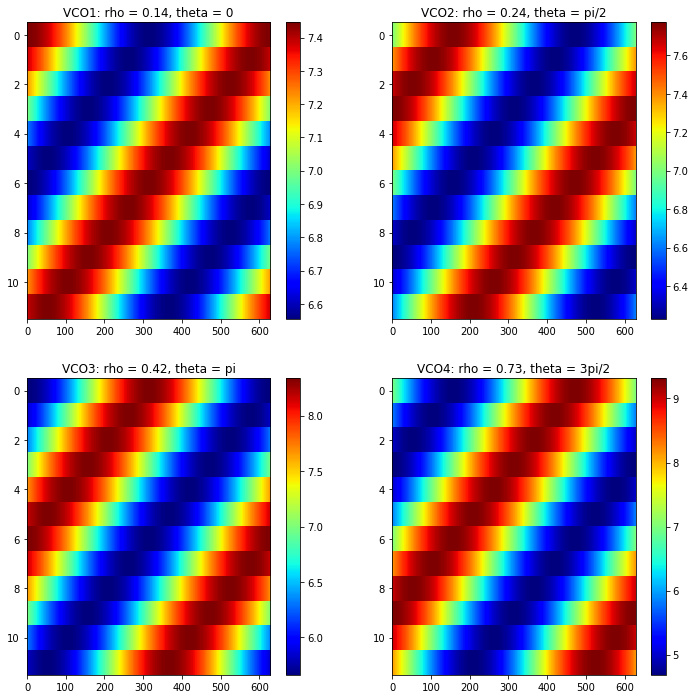

In [12]:
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.title('VCO1: rho = 0.14, theta = 0')
plt.imshow(VCO1.ring_activity(path_pol), aspect='auto',cmap='jet')
plt.colorbar()
plt.subplot(222)
plt.title('VCO2: rho = 0.24, theta = pi/2')
plt.imshow(VCO2.ring_activity(path_pol), aspect='auto',cmap='jet')
plt.colorbar()
plt.subplot(223)
plt.title('VCO3: rho = 0.42, theta = pi')
plt.imshow(VCO3.ring_activity(path_pol), aspect='auto',cmap='jet')
plt.colorbar()
plt.subplot(224)
plt.title('VCO4: rho = 0.73, theta = 3pi/2')
plt.imshow(VCO4.ring_activity(path_pol), aspect='auto',cmap='jet')
plt.colorbar()

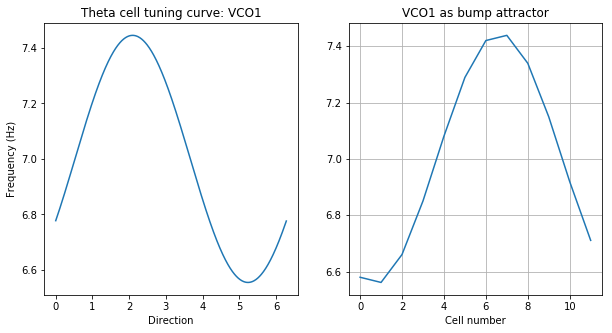

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('Theta cell tuning curve: VCO1')
plt.plot(path_pol[:,1], VCO1.cell_activity(8,path_pol))
plt.ylabel('Frequency (Hz)')
plt.xlabel('Direction')

plt.subplot(122)
plt.title('VCO1 as bump attractor')
plt.plot(range(12),VCO1.ring_activity(path_pol)[:,280])
plt.xlabel('Cell number')
plt.grid()

## Demo: Forming Hippocampal Nav. Cells from VCOs

Now we make a matrix of VCOs with 12 columns and 6 rows. The columns are different preferred directions and the rows different speed slopes.

In [14]:
minrho = 0.14
rotation_angle = 0
rhos = minrho * (np.sqrt(3)**(np.arange(6)))
thetas = np.pi + rotation_angle + 2*np.pi*(np.arange(12))/12. 

VCO_matrix=[[],[],[],[],[],[]]
for row in range(6):
    for col in range(12):
        VCO_matrix[row].append(RingOscillator(12, rhos[row], thetas[col], 0))

In [15]:
ss = np.linspace(-5,5,50)
xx, yy = np.meshgrid(ss,ss)

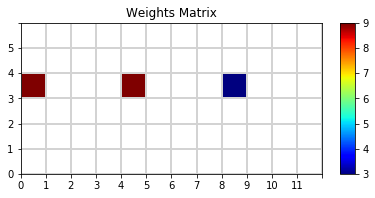

In [16]:
weights = np.full([6,12],np.nan)

# border cell
#weights[:,9] = [2,3,5,7,11,9]
# large grid
weights[3,0] = 9; weights[3,4] = 9; weights[3,8] = 3
#small grid
#weights[3,1] = 1; weights[3,5] = 9; weights[3,9] = 3
#place cell
#rotation_angle = 8*np.pi/6. #orientation of the tuning function is zero by default
#weights[2,:] = [11,11,0,0,0,0,0,0,11,10,10,10]
#weights[3,:] = [10,11,0,0,0,0,0,0,10,10,10,10]
#weights[4,:] = [10,11,0,1,2,1,0,0,10, 9, 8, 9]
#curved border
#for col in [0,1,2,3,4,11]:
#    weights[:,col] = [1,1,2,4,7,1]
#lumpy border
#weights[:,0] = [1,2,3,5,8,3]
#weights[2,2] = 6; weights[3,2] = 1
# multi-field dentate place cell in square box
#weights[2,:] = [8,0,1,1,7,4,2,7,8,8,4,2]
#weights[3,:] = [3,0,3,0,5,0,1,4,5,9,9,11]
#weights[4,:] = [0,2,2,10,7,0,0,5,6,2,6,4]

# Plot weights matrix
plot_weights(weights)

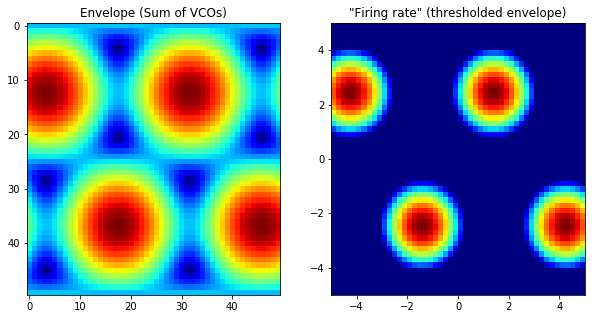

In [17]:
Esum = np.zeros([50,50],dtype='complex128')
for row in range(weights.shape[0]):
    for col in range(weights.shape[1]):
        if (not np.isnan(weights[row,col])):
            cell_response = VCO_matrix[row][col].cell_activity_2(int(weights[row,col]), xx, yy,0)
            Esum = Esum + cell_response

Esum = abs(Esum)
Emax = np.max(Esum)
EE = Esum-0.65*Emax
EE[EE<0] = 0
Emax =np.max(EE)

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('Envelope (Sum of VCOs)')
plt.imshow(Esum,aspect='auto',cmap='jet')
plt.subplot(122)
plt.title('"Firing rate" (thresholded envelope)')
plt.imshow(EE/Emax,extent=(-5,5,-5,5),aspect='auto',cmap='jet')

## Demo: 2-D Random Walk
Cells firing over 2D random walk

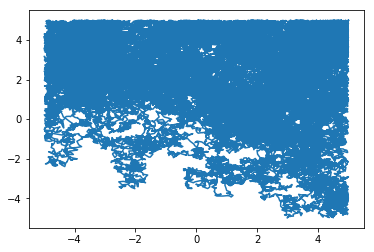

In [18]:
N=75000
path = randwalk(5,N,10)

plt.plot(path[:,0],path[:,1])

In [19]:
EsumRW = np.zeros(N,dtype='complex128')
for row in range(weights.shape[0]):
    for col in range(weights.shape[1]):
        if (not np.isnan(weights[row,col])):
            cell_response = VCO_matrix[row][col].cell_activity_2(int(weights[row,col]), path[:,0], -path[:,1])
            EsumRW = EsumRW + cell_response
print('EsumRW shape:',EsumRW.shape)

EsumRW shape: (75000,)


(75000, 1, 2)
(74999, 2, 2)


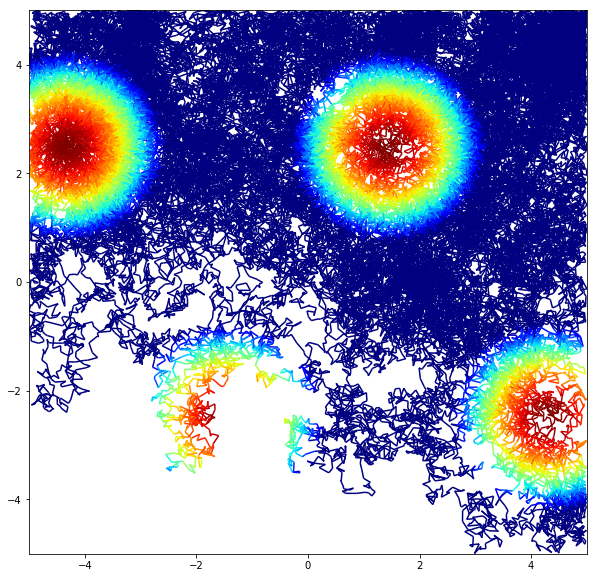

In [20]:
plot_randwalk(path,EsumRW)

## Adding Noise to intra-VCO Timing

In [21]:
VCO_reg = RingOscillator(12,0.14,0)
VCO_jitter = RingOscillator(12,0.14,0,1)

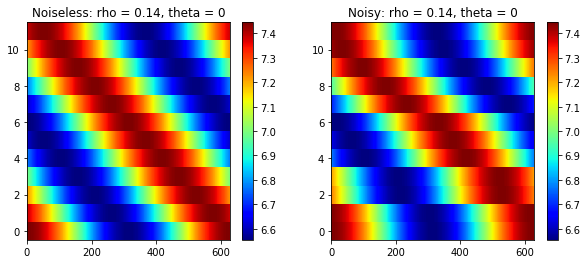

In [22]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.title('Noiseless: rho = 0.14, theta = 0')
plt.imshow(VCO_reg.ring_activity(path_pol), aspect='auto',cmap='jet',origin='lower')
plt.colorbar()
plt.subplot(122)
plt.title('Noisy: rho = 0.14, theta = 0')
plt.imshow(VCO_jitter.ring_activity(path_pol), aspect='auto',cmap='jet',origin='lower')
plt.colorbar()

## Demo: HC Nav Cells with intra-VCO Noise

In [23]:
jitter=np.pi/6

VCO_matrix_noisy=[[],[],[],[],[],[]]
for row in range(6):
    for col in range(12):
        VCO_matrix_noisy[row].append(RingOscillator(12, rhos[row], thetas[col], jitter))

In [24]:
weights_choice = 6

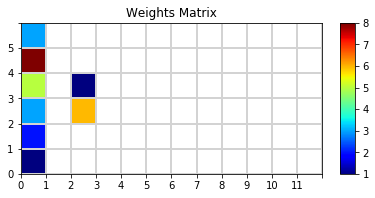

In [25]:
weights_noisy = np.full([6,12],np.nan)

# border cell
if weights_choice == 1:
    weights_noisy[:,9] = [2,3,5,7,11,9]
# large grid
elif weights_choice == 2:
    weights_noisy[3,0] = 9; weights_noisy[3,4] = 9; weights_noisy[3,8] = 3
#small grid
elif weights_choice == 3:
    weights_noisy[3,1] = 1; weights_noisy[3,5] = 9; weights_noisy[3,9] = 3
#place cell
elif weights_choice == 4:
    rotation_angle = 8*np.pi/6. #orientation of the tuning function is zero by default
    weights_noisy[2,:] = [11,11,0,0,0,0,0,0,11,10,10,10]
    weights_noisy[3,:] = [10,11,0,0,0,0,0,0,10,10,10,10]
    weights_noisy[4,:] = [10,11,0,1,2,1,0,0,10, 9, 8, 9]
#curved border
elif weights_choice == 5:
    for col in [0,1,2,3,4,11]:
        weights_noisy[:,col] = [1,1,2,4,7,1]
#lumpy border
elif weights_choice == 6:
    weights_noisy[:,0] = [1,2,3,5,8,3]
    weights_noisy[2,2] = 6; weights_noisy[3,2] = 1
# multi-field dentate place cell in square box
elif weights_choice == 7:
    weights_noisy[2,:] = [8,0,1,1,7,4,2,7,8,8,4,2]
    weights_noisy[3,:] = [3,0,3,0,5,0,1,4,5,9,9,11]
    weights_noisy[4,:] = [0,2,2,10,7,0,0,5,6,2,6,4]

# Plot weights matrix
plot_weights(weights_noisy)

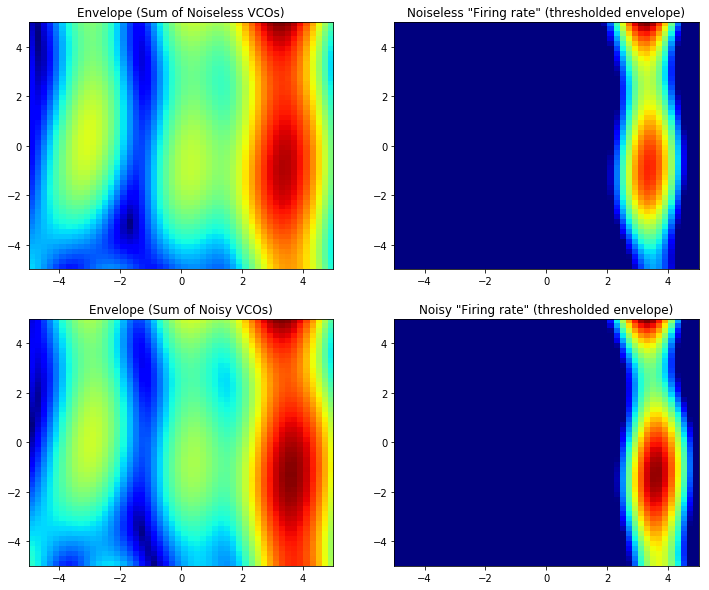

In [26]:
Esum = np.zeros([50,50],dtype='complex128')
for row in range(weights_noisy.shape[0]):
    for col in range(weights_noisy.shape[1]):
        if (not np.isnan(weights_noisy[row,col])):
            cell_response = VCO_matrix[row][col].cell_activity_2(int(weights_noisy[row,col]), xx, yy)
            Esum = Esum + cell_response

Esum = abs(Esum)
Emax = np.max(Esum)
EE = Esum-0.65*Emax
EE[EE<0] = 0
Emax =np.max(EE)

Esum_noisy = np.zeros([50,50],dtype='complex128')
for row in range(weights_noisy.shape[0]):
    for col in range(weights_noisy.shape[1]):
        if (not np.isnan(weights_noisy[row,col])):
            cell_response = VCO_matrix_noisy[row][col].cell_activity_2(int(weights_noisy[row,col]), xx, yy)
            Esum_noisy = Esum_noisy + cell_response

Esum_noisy = abs(Esum_noisy)
Emax_noisy = np.max(Esum_noisy)
EE_noisy = Esum_noisy-0.65*Emax_noisy
EE_noisy[EE_noisy<0] = 0
Emax_noisy =np.max(EE_noisy)

plt.figure(figsize=(12,10))

plt.subplot(221)
plt.title('Envelope (Sum of Noiseless VCOs)')
plt.imshow(Esum,aspect='auto',cmap='jet',extent=(-5,5,-5,5))
plt.subplot(222)
plt.title('Noiseless "Firing rate" (thresholded envelope)')
plt.imshow(EE/Emax,extent=(-5,5,-5,5),aspect='auto',cmap='jet')

plt.subplot(223)
plt.title('Envelope (Sum of Noisy VCOs)')
plt.imshow(Esum_noisy,aspect='auto',cmap='jet',extent=(-5,5,-5,5))
plt.subplot(224)
plt.title('Noisy "Firing rate" (thresholded envelope)')
plt.imshow(EE_noisy/Emax_noisy,extent=(-5,5,-5,5),aspect='auto',cmap='jet')

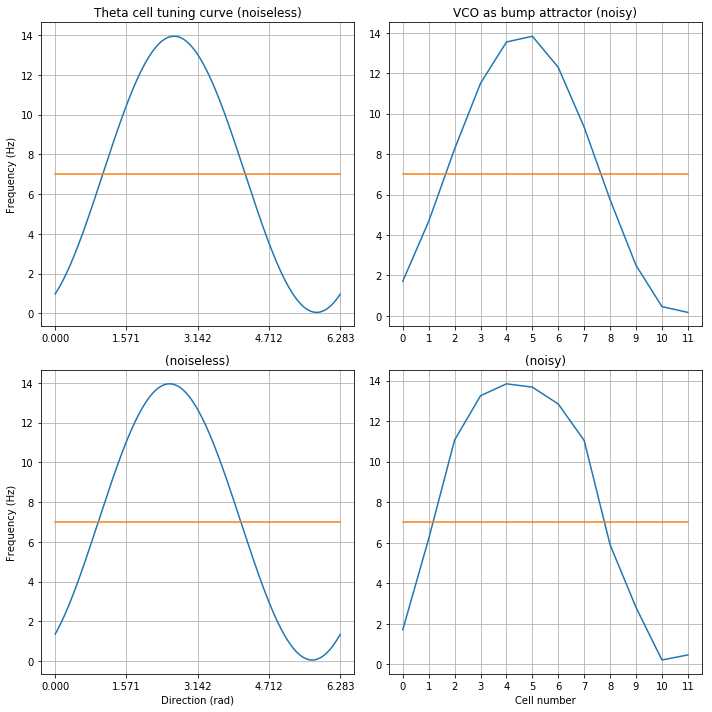

In [27]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.title('Theta cell tuning curve (noiseless)')
plt.plot(path_pol[:,1], VCO_matrix[5][4].cell_activity(5,path_pol), path_pol[:,1],np.ones_like(path_pol[:,1])*7)
plt.ylabel('Frequency (Hz)')
plt.xticks(np.arange(0,5/2*np.pi,np.pi/2))
plt.grid()

plt.subplot(222)
plt.title('VCO as bump attractor (noisy)')
plt.plot(range(12),VCO_matrix[5][4].ring_activity(path_pol)[:,280], range(12),np.ones(12)*7)
plt.xticks(np.arange(0,12,1))
plt.grid()


plt.subplot(223)
plt.title('(noiseless)')
plt.plot(path_pol[:,1], VCO_matrix_noisy[5][4].cell_activity(5,path_pol), path_pol[:,1],np.ones_like(path_pol[:,1])*7)
plt.xticks(np.arange(0,5/2*np.pi,np.pi/2))
plt.grid()
plt.ylabel('Frequency (Hz)')
plt.xlabel('Direction (rad)')

plt.subplot(224)
plt.title('(noisy)')
plt.xlabel('Cell number')
plt.xticks(np.arange(0,12,1))
plt.plot(range(12),VCO_matrix_noisy[5][4].ring_activity(path_pol)[:,280], range(12),np.ones(12)*7)
plt.grid()

plt.tight_layout()

## Random projections of VCOmatrix rows

In [28]:
num_inputs = 3

w = np.full([6,12], np.nan)
random_cells = np.random.randint(12, size=num_inputs)
random_cols = np.arange(12)
np.random.shuffle(random_cols)

w_x = np.random.randint(6)
#w_x = 1
w_y = random_cols[:num_inputs]

for i in range(num_inputs):
    w[w_x, w_y[i]] = random_cells[i]

#plot_weights(w)

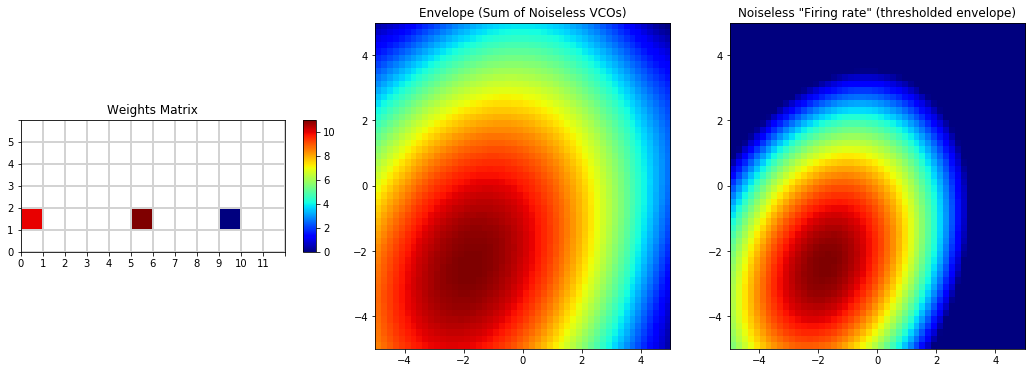

In [29]:
Esum = np.zeros([50,50],dtype='complex128')
for row in range(w.shape[0]):
    for col in range(w.shape[1]):
        if (not np.isnan(w[row,col])):
            cell_response = VCO_matrix[row][col].cell_activity_2(int(w[row,col]), xx, yy)
            Esum = Esum + cell_response

Esum = abs(Esum)
Emax = np.max(Esum)
EE = Esum-0.65*Emax
EE[EE<0] = 0
Emax =np.max(EE)

plt.figure(figsize=(18,6))


plt.subplot(131)
(x_size, y_size) = w.shape
im = plt.imshow(w,cmap='jet',origin='lower')
ax = plt.gca()
plt.title('Weights Matrix')
ax.grid(which='both', color='lightgray', linestyle='-', linewidth=2)
ax.set_xticks(np.arange(-0.5,12,1))
ax.set_yticks(np.arange(-0.5,6,1))
ax.set_xticklabels(np.arange(0, 12, 1))
ax.set_yticklabels(np.arange(0, 6, 1))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.25)
plt.colorbar(im, cax=cax)
plt.subplot(132)
plt.title('Envelope (Sum of Noiseless VCOs)')
plt.imshow(Esum,aspect='auto',cmap='jet',extent=(-5,5,-5,5))
plt.subplot(133)
plt.title('Noiseless "Firing rate" (thresholded envelope)')
plt.imshow(EE/Emax,extent=(-5,5,-5,5),aspect='auto',cmap='jet')

Higher $w_x$ values (corresponding to lower rows in the weights matrix) correspond to higher frequency grids. Higher $w_x$ values correspond to higher $\rho$ values, so these VCOs are more sensitive to velocity (I think...). By looking at a larger arena, we can see the gridness of the small $w_x$ values.

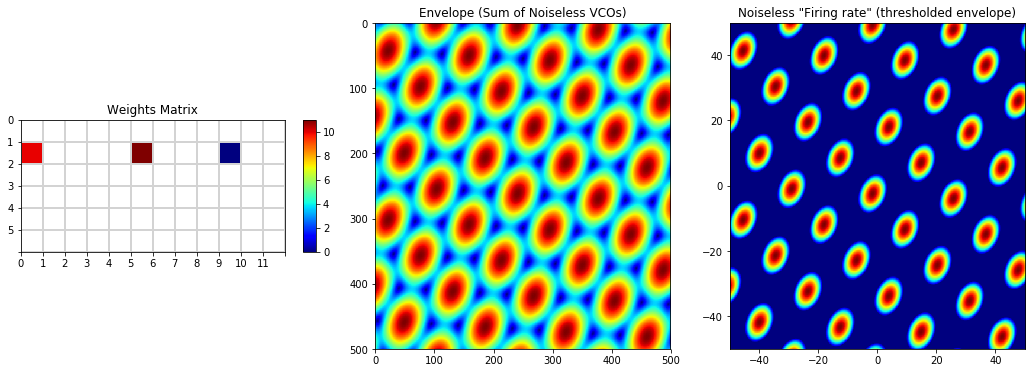

In [30]:
size = 50

ss_big = np.linspace(-size,size,10*size)
xx_big, yy_big = np.meshgrid(ss_big,ss_big)
if w_x < 2:
    Esum = np.zeros([10*size,10*size],dtype='complex128')
    for row in range(w.shape[0]):
        for col in range(w.shape[1]):
            if (not np.isnan(w[row,col])):
                cell_response = VCO_matrix[row][col].cell_activity_2(int(w[row,col]), xx_big, yy_big)
                Esum = Esum + cell_response

    Esum = abs(Esum)
    Emax = np.max(Esum)
    EE = Esum-0.65*Emax
    EE[EE<0] = 0
    Emax =np.max(EE)

    plt.figure(figsize=(18,6))


    plt.subplot(131)
    (x_size, y_size) = w.shape
    im = plt.imshow(w,cmap='jet')
    ax = plt.gca()
    plt.title('Weights Matrix')
    ax.grid(which='both', color='lightgray', linestyle='-', linewidth=2)
    ax.set_xticks(np.arange(-0.5,12,1))
    ax.set_yticks(np.arange(-0.5,6,1))
    ax.set_xticklabels(np.arange(0, 12, 1))
    ax.set_yticklabels(np.arange(0, 6, 1))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.25)
    plt.colorbar(im, cax=cax)
    plt.subplot(132)
    plt.title('Envelope (Sum of Noiseless VCOs)')
    plt.imshow(Esum,aspect='auto',cmap='jet')
    plt.subplot(133)
    plt.title('Noiseless "Firing rate" (thresholded envelope)')
    plt.imshow(EE/Emax,extent=(-size,size,-size,size),aspect='auto',cmap='jet')

It makes sense that we should have 3 inputs to create a hexagonal grid: which cells in which columns determine the phases and orientations of the added sinusoids.

#### Things to try out:
- What effect does changing cell choices have on the output grid?
- What effect does changing cell column but retaining cell choices have on the output grid?
- What effect does changing cell row but retaining etc. have on the output grid?

### Demo: Shift grid through cell choices
Each ring oscillator determines a particular spatial component of the interference pattern; changing the cell choice in the specified ring oscillators shifts the grid along one of the three axes.

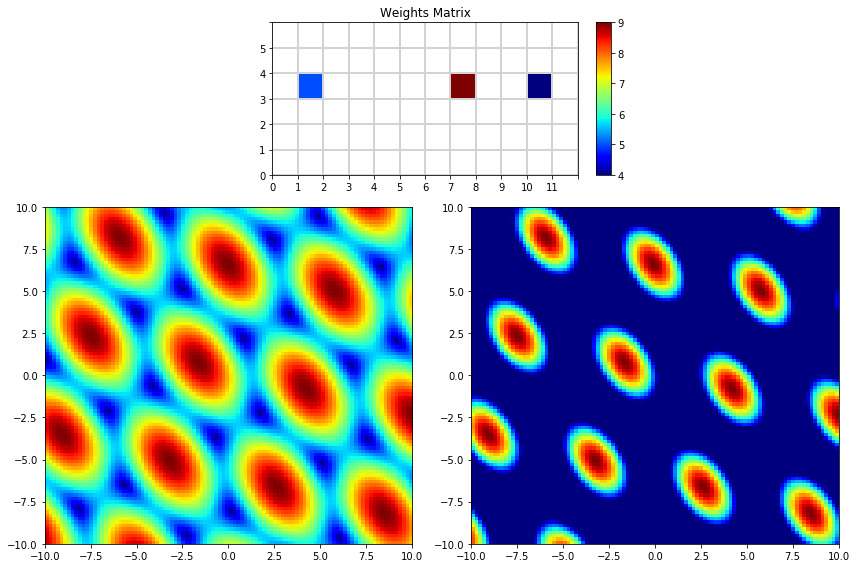

In [31]:
size = 10

weights = np.full([6,12], np.nan)
weights[3,1] = 5
weights[3,7] = 9
weights[3,10] = 4

orig_norm, orig_sum = hcn_activity(VCO_matrix_noisy, weights, size)
plt.figure(figsize=(12,8))

axw = plt.subplot2grid((3,4),(0,1),colspan=2)
(x_size, y_size) = weights.shape
im = plt.imshow(weights,cmap='jet',origin='lower')
ax = plt.gca()
plt.title('Weights Matrix')
ax.grid(which='both', color='lightgray', linestyle='-', linewidth=2)
ax.set_xticks(np.arange(-0.5,12,1))
ax.set_yticks(np.arange(-0.5,6,1))
ax.set_xticklabels(np.arange(0, 12, 1))
ax.set_yticklabels(np.arange(0, 6, 1))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.25)
plt.colorbar(im, cax=cax)

axL = plt.subplot2grid((3,4),(1,0),colspan=2,rowspan=2)
plt.imshow(orig_sum,extent=(-size,size,-size,size),aspect='auto',cmap='jet')

axR = plt.subplot2grid((3,4),(1,2),colspan=2,rowspan=2)
plt.imshow(orig_norm,extent=(-size,size,-size,size),aspect='auto',cmap='jet')

plt.tight_layout()

In [32]:
weights_al = np.copy(weights)
weights_al[3,1] = weights[3,1] - 1
al_norm, al_sum = hcn_activity(VCO_matrix_noisy,weights_al,size)
weights_ag = np.copy(weights)
weights_ag[3,1] = weights[3,1] + 1
ag_norm, ag_sum = hcn_activity(VCO_matrix_noisy,weights_ag,size)
weights_bl = np.copy(weights)
weights_bl[3,7] = weights[3,7] - 1
bl_norm, bl_sum = hcn_activity(VCO_matrix_noisy,weights_bl,size)
weights_bg = np.copy(weights)
weights_bg[3,7] = weights[3,7] + 1
bg_norm, bg_sum = hcn_activity(VCO_matrix_noisy,weights_bg,size)
weights_cl = np.copy(weights)
weights_cl[3,10] = weights[3,10] - 1
cl_norm, cl_sum = hcn_activity(VCO_matrix_noisy,weights_cl,size)
weights_cg = np.copy(weights)
weights_cg[3,10] = weights[3,10] + 1
cg_norm, cg_sum = hcn_activity(VCO_matrix_noisy,weights_cg,size)

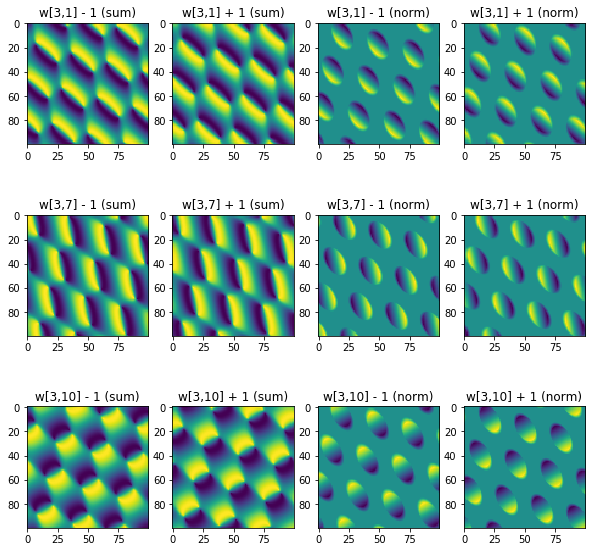

In [33]:
plt.figure(figsize=(10,10))
plt.subplot(3,4,1)
plt.title('w[3,1] - 1 (sum)')
plt.imshow(al_sum - orig_sum)
plt.subplot(3,4,2)
plt.title('w[3,1] + 1 (sum)')
plt.imshow(ag_sum - orig_sum)
plt.subplot(3,4,3)
plt.title('w[3,1] - 1 (norm)')
plt.imshow(al_norm - orig_norm)
plt.subplot(3,4,4)
plt.title('w[3,1] + 1 (norm)')
plt.imshow(ag_norm - orig_norm)
plt.subplot(3,4,5)
plt.title('w[3,7] - 1 (sum)')
plt.imshow(bl_sum - orig_sum)
plt.subplot(3,4,6)
plt.title('w[3,7] + 1 (sum)')
plt.imshow(bg_sum - orig_sum)
plt.subplot(3,4,7)
plt.title('w[3,7] - 1 (norm)')
plt.imshow(bl_norm - orig_norm)
plt.subplot(3,4,8)
plt.title('w[3,7] + 1 (norm)')
plt.imshow(bg_norm - orig_norm)
plt.subplot(3,4,9)
plt.title('w[3,10] - 1 (sum)')
plt.imshow(cl_sum - orig_sum)
plt.subplot(3,4,10)
plt.title('w[3,10] + 1 (sum)')
plt.imshow(cg_sum - orig_sum)
plt.subplot(3,4,11)
plt.title('w[3,10] - 1 (norm)')
plt.imshow(cl_norm - orig_norm)
plt.subplot(3,4,12)
plt.title('w[3,10] + 1 (norm)')
plt.imshow(cg_norm - orig_norm)


### Demo: Changing cell columns
Column has to do with $\theta$, i.e. preferred direction... so maybe this has something to do with that? It's unclear so far, but should definitely be looked into.

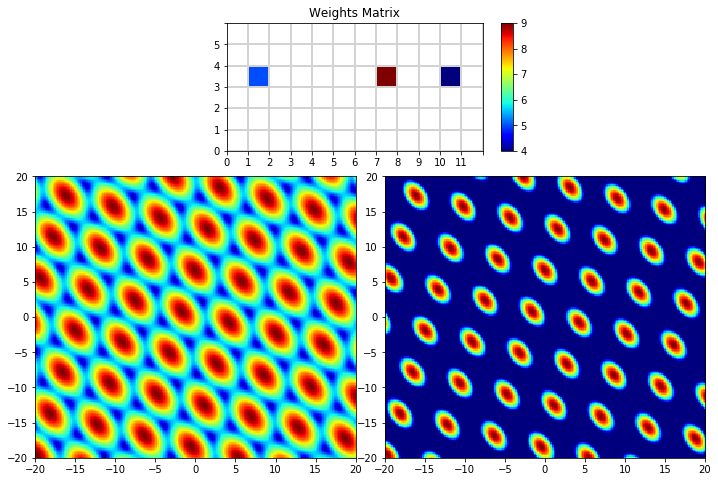

In [34]:
size = 20

weights = np.full([6,12], np.nan)
weights[3,1] = 5
weights[3,7] = 9
weights[3,10] = 4

orig_norm, orig_sum = hcn_activity(VCO_matrix_noisy, weights, size)
plt.figure(figsize=(12,8))

axw = plt.subplot2grid((3,4),(0,1),colspan=2)
(x_size, y_size) = weights.shape
im = plt.imshow(weights,cmap='jet',origin='lower')
ax = plt.gca()
plt.title('Weights Matrix')
ax.grid(which='both', color='lightgray', linestyle='-', linewidth=2)
ax.set_xticks(np.arange(-0.5,12,1))
ax.set_yticks(np.arange(-0.5,6,1))
ax.set_xticklabels(np.arange(0, 12, 1))
ax.set_yticklabels(np.arange(0, 6, 1))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.25)
plt.colorbar(im, cax=cax)

axL = plt.subplot2grid((3,4),(1,0),colspan=2,rowspan=2)
plt.imshow(orig_sum,extent=(-size,size,-size,size),aspect='auto',cmap='jet')

axR = plt.subplot2grid((3,4),(1,2),colspan=2,rowspan=2)
plt.imshow(orig_norm,extent=(-size,size,-size,size),aspect='auto',cmap='jet')

In [35]:
w_AL = np.copy(weights)
w_AL[3,0] = weights[3,1]; w_AL[3,1] = np.nan;
w_AR = np.copy(weights)
w_AR[3,2] = weights[3,1]; w_AR[3,1] = np.nan;
w_BL = np.copy(weights)
w_BL[3,6] = weights[3,7]; w_BL[3,7] = np.nan;
w_BR = np.copy(weights)
w_BR[3,8] = weights[3,7]; w_BR[3,7] = np.nan;
w_CL = np.copy(weights)
w_CL[3,9] = weights[3,10]; w_CL[3,10] = np.nan;
w_CR = np.copy(weights)
w_CR[3,11] = weights[3,10]; w_CR[3,10] = np.nan;


In [36]:
AL_norm, AL_sum = hcn_activity(VCO_matrix_noisy,w_AL,size)
AR_norm, AR_sum = hcn_activity(VCO_matrix_noisy,w_AR,size)
BL_norm, BL_sum = hcn_activity(VCO_matrix_noisy,w_BL,size)
BR_norm, BR_sum = hcn_activity(VCO_matrix_noisy,w_BR,size)
CL_norm, CL_sum = hcn_activity(VCO_matrix_noisy,w_CL,size)
CR_norm, CR_sum = hcn_activity(VCO_matrix_noisy,w_CR,size)

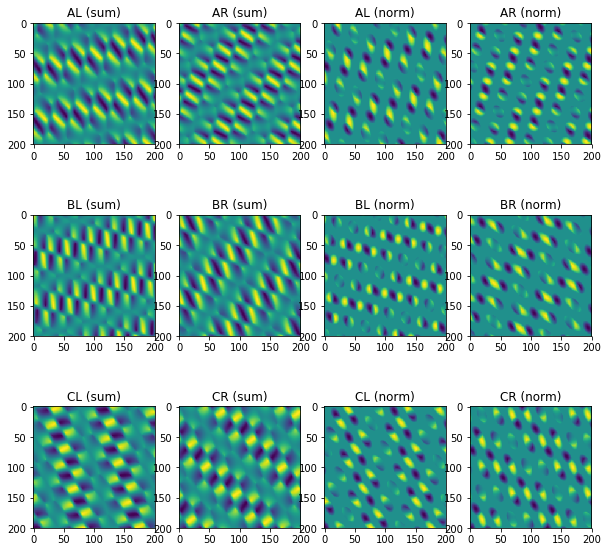

In [37]:
plt.figure(figsize=(10,10))
plt.subplot(3,4,1)
plt.title('AL (sum)')
plt.imshow(AL_sum - orig_sum)
plt.subplot(3,4,2)
plt.title('AR (sum)')
plt.imshow(AR_sum - orig_sum)
plt.subplot(3,4,3)
plt.title('AL (norm)')
plt.imshow(AL_norm - orig_norm)
plt.subplot(3,4,4)
plt.title('AR (norm)')
plt.imshow(AR_norm - orig_norm)
plt.subplot(3,4,5)
plt.title('BL (sum)')
plt.imshow(BL_sum - orig_sum)
plt.subplot(3,4,6)
plt.title('BR (sum)')
plt.imshow(BR_sum - orig_sum)
plt.subplot(3,4,7)
plt.title('BL (norm)')
plt.imshow(BL_norm - orig_norm)
plt.subplot(3,4,8)
plt.title('BR (norm)')
plt.imshow(BR_norm - orig_norm)
plt.subplot(3,4,9)
plt.title('CL (sum)')
plt.imshow(CL_sum - orig_sum)
plt.subplot(3,4,10)
plt.title('CR (sum)')
plt.imshow(CR_sum - orig_sum)
plt.subplot(3,4,11)
plt.title('CL (norm)')
plt.imshow(CL_norm - orig_norm)
plt.subplot(3,4,12)
plt.title('CR (norm)')
plt.imshow(CR_norm - orig_norm)

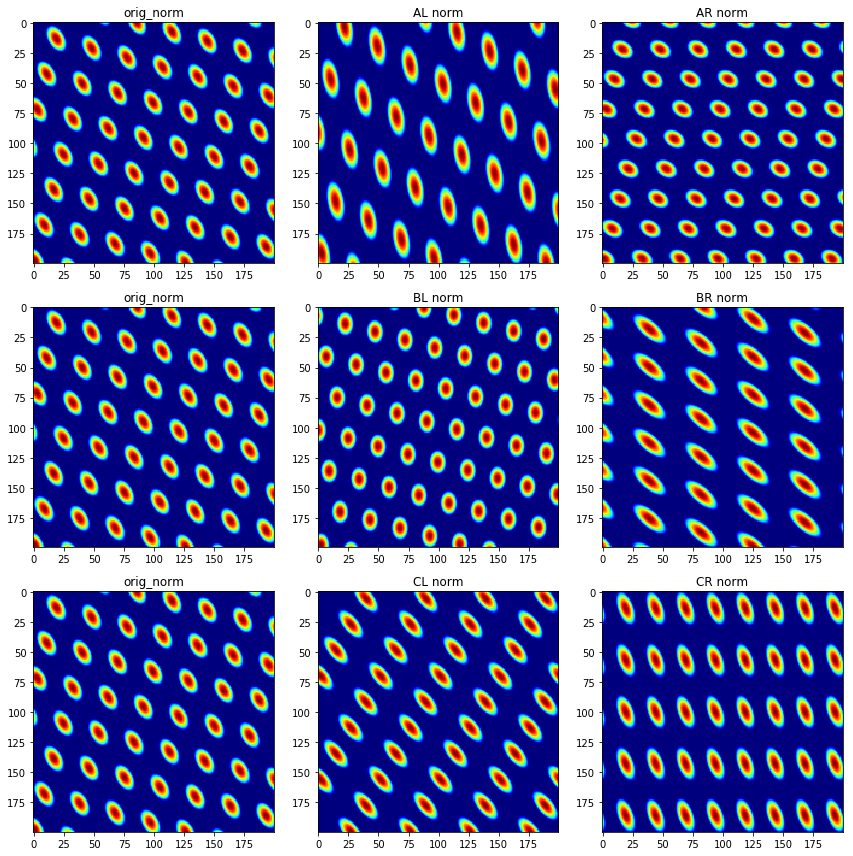

In [38]:
plt.figure(figsize=(12,12))
plt.subplot(3,3,1)
plt.title('orig_norm')
plt.imshow(orig_norm, cmap='jet')
plt.subplot(3,3,2)
plt.title('AL norm')
plt.imshow(AL_norm, cmap='jet')
plt.subplot(3,3,3)
plt.title('AR norm')
plt.imshow(AR_norm, cmap='jet')
plt.subplot(3,3,4)
plt.title('orig_norm')
plt.imshow(orig_norm, cmap='jet')
plt.subplot(3,3,5)
plt.title('BL norm')
plt.imshow(BL_norm, cmap='jet')
plt.subplot(3,3,6)
plt.title('BR norm')
plt.imshow(BR_norm, cmap='jet')
plt.subplot(3,3,7)
plt.title('orig_norm')
plt.imshow(orig_norm, cmap='jet')
plt.subplot(3,3,8)
plt.title('CL norm')
plt.imshow(CL_norm, cmap='jet')
plt.subplot(3,3,9)
plt.title('CR norm')
plt.imshow(CR_norm, cmap='jet')

plt.tight_layout()

### Demo: Changing cell rows

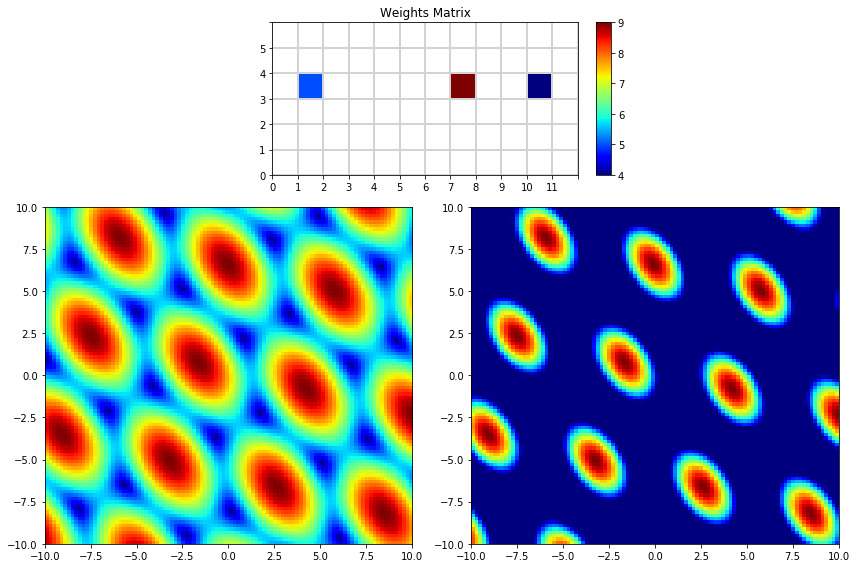

In [39]:
size = 10

weights = np.full([6,12], np.nan)
weights[3,1] = 5
weights[3,7] = 9
weights[3,10] = 4

orig_norm, orig_sum = hcn_activity(VCO_matrix_noisy, weights, size)
plt.figure(figsize=(12,8))

axw = plt.subplot2grid((3,4),(0,1),colspan=2)
(x_size, y_size) = weights.shape
im = plt.imshow(weights,cmap='jet',origin='lower')
ax = plt.gca()
plt.title('Weights Matrix')
ax.grid(which='both', color='lightgray', linestyle='-', linewidth=2)
ax.set_xticks(np.arange(-0.5,12,1))
ax.set_yticks(np.arange(-0.5,6,1))
ax.set_xticklabels(np.arange(0, 12, 1))
ax.set_yticklabels(np.arange(0, 6, 1))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.25)
plt.colorbar(im, cax=cax)

axL = plt.subplot2grid((3,4),(1,0),colspan=2,rowspan=2)
plt.imshow(orig_sum,extent=(-size,size,-size,size),aspect='auto',cmap='jet')

axR = plt.subplot2grid((3,4),(1,2),colspan=2,rowspan=2)
plt.imshow(orig_norm,extent=(-size,size,-size,size),aspect='auto',cmap='jet')
plt.tight_layout()

Here (above) we plot the original grid cell, which sums inputs from three VCOs that have the following conditions:

In [40]:
print(VCO_matrix_noisy[3][1])
print(VCO_matrix_noisy[3][7])
print(VCO_matrix_noisy[3][10])

RingOscillator[N=12, (rho, theta)=(0.7274613391789284, 3.665191), phi_n=0.5235987755982988]
RingOscillator[N=12, (rho, theta)=(0.7274613391789284, 6.806784), phi_n=0.5235987755982988]
RingOscillator[N=12, (rho, theta)=(0.7274613391789284, 8.377580), phi_n=0.5235987755982988]


In [41]:
weights_up1 = np.copy(weights)
weights_up1[2,:] = weights[3,:]; weights_up1[3,:] = np.nan
weights_up2 = np.copy(weights)
weights_up2[1,:] = weights[3,:]; weights_up2[3,:] = np.nan
weights_dn1 = np.copy(weights)
weights_dn1[4,:] = weights[3,:]; weights_dn1[3,:] = np.nan
weights_dn2 = np.copy(weights)
weights_dn2[5,:] = weights[3,:]; weights_dn2[3,:] = np.nan

In [42]:
up1_norm, up1_sum = hcn_activity(VCO_matrix_noisy,weights_up1,size)
up2_norm, up2_sum = hcn_activity(VCO_matrix_noisy,weights_up2,size)
dn1_norm, dn1_sum = hcn_activity(VCO_matrix_noisy,weights_dn1,size)
dn2_norm, dn2_sum = hcn_activity(VCO_matrix_noisy,weights_dn2,size)

In [43]:
for row in range(weights_up1.shape[0]):
    for col in range(weights_up1.shape[1]):
        if (not np.isnan(weights_dn2[row,col])):
            print(VCO_matrix_noisy[row][col])

RingOscillator[N=12, (rho, theta)=(2.182384017536785, 3.665191), phi_n=0.5235987755982988]
RingOscillator[N=12, (rho, theta)=(2.182384017536785, 6.806784), phi_n=0.5235987755982988]
RingOscillator[N=12, (rho, theta)=(2.182384017536785, 8.377580), phi_n=0.5235987755982988]


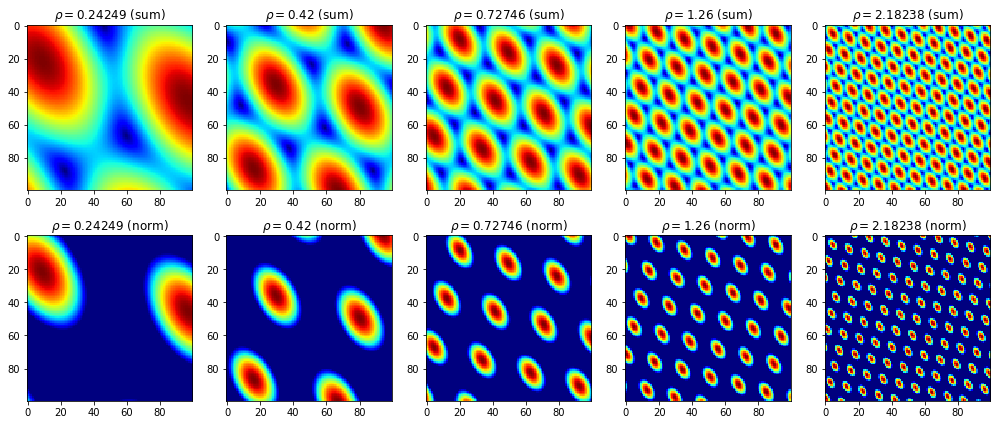

In [44]:
plt.figure(figsize=(14,6))
plt.subplot(2,5,1)
plt.imshow(up2_sum,cmap='jet')
plt.title(r'$\rho = 0.24249$ (sum)')
plt.subplot(2,5,6)
plt.imshow(up2_norm,cmap='jet')
plt.title(r'$\rho = 0.24249$ (norm)')
plt.subplot(2,5,2)
plt.imshow(up1_sum,cmap='jet')
plt.title(r'$\rho = 0.42$ (sum)')
plt.subplot(2,5,7)
plt.imshow(up1_norm,cmap='jet')
plt.title(r'$\rho = 0.42$ (norm)')
plt.subplot(2,5,3)
plt.imshow(orig_sum,cmap='jet')
plt.title(r'$\rho = 0.72746$ (sum)')
plt.subplot(2,5,8)
plt.imshow(orig_norm,cmap='jet')
plt.title(r'$\rho = 0.72746$ (norm)')
plt.subplot(2,5,4)
plt.imshow(dn1_sum,cmap='jet')
plt.title(r'$\rho = 1.26$ (sum)')
plt.subplot(2,5,9)
plt.imshow(dn1_norm,cmap='jet')
plt.title(r'$\rho = 1.26$ (norm)')
plt.subplot(2,5,5)
plt.imshow(dn2_sum,cmap='jet')
plt.title(r'$\rho = 2.18238$ (sum)')
plt.subplot(2,5,10)
plt.imshow(dn2_norm,cmap='jet')
plt.title(r'$\rho = 2.18238$ (norm)')

plt.tight_layout()

## Creating a series of random-projection grid cells

In [45]:
ringsize = 12
minrho = 0.14
rotation_angle = 0
rhos = minrho * (np.sqrt(3)**(np.arange(6)))
thetas = np.pi + rotation_angle + 2*np.pi*(np.arange(12))/12. 
jitter = 1

VCOmat = [[],[],[],[],[],[]]
for row in range(6):
    for col in range(12):
        VCOmat[row].append(RingOscillator(ringsize, rhos[row], thetas[col], jitter))

In [46]:
n_input = 3
n_mats = 1000
rd_gweights = np.full([6,12,n_mats], np.nan)

for mat in range(n_mats):
    random_cells = np.random.randint(12, size=num_inputs)
    random_cols = np.arange(12)
    np.random.shuffle(random_cols)
    w_x = np.random.randint(6)
    w_y = random_cols[:num_inputs]

    for i in range(n_input):
        rd_gweights[w_x, w_y[i],mat] = random_cells[i]


In [47]:
size = 10
rd_gnorms = np.zeros((10*size,10*size,n_mats))

In [48]:
for i in range(n_mats):
    gnorm, _ = hcn_activity(VCOmat, rd_gweights[:,:,i], size)
    rd_gnorms[:,:,i] = gnorm

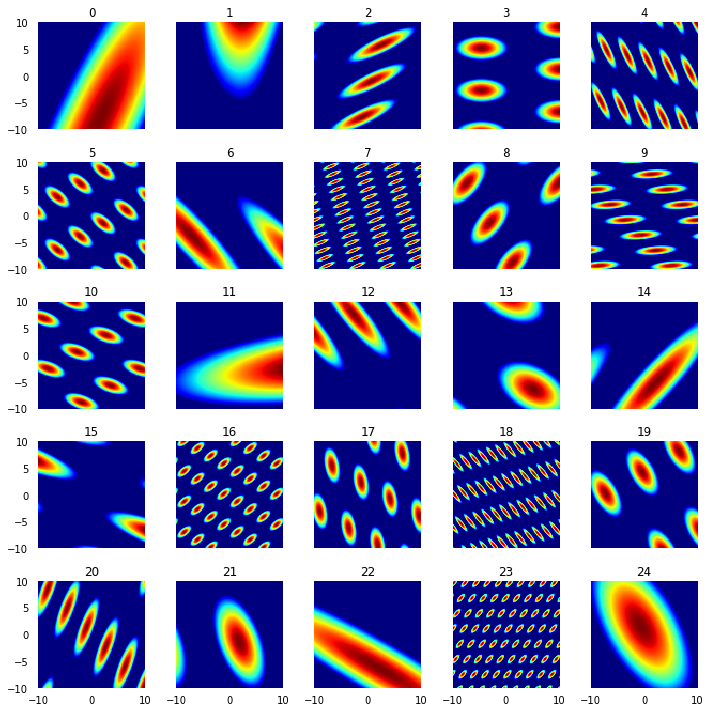

In [49]:
fig, axes = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(10,10))
axes_list = [item for sublist in axes for item in sublist] 

for idx in range(25):
    ax = axes_list.pop(0)
    #selection.plot(x='Year', y='GDP_per_capita', label=countryname, ax=ax, legend=False, clip_on=False)
    ax.imshow(rd_gnorms[:,:,idx],cmap='jet',extent=(-size,size,-size,size))
    ax.set_title(idx)
    #'''
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    #'''

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout()

### Making Place Cells

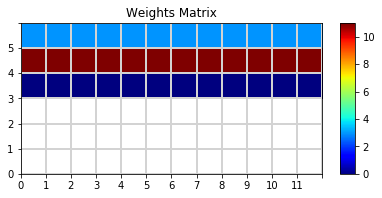

In [50]:
place_weights = np.full([6,12],np.nan)
place_weights[3] = 0
place_weights[4] = 11
place_weights[5] = 3

plot_weights(place_weights)

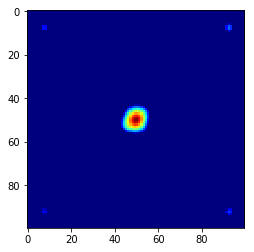

In [51]:
testnorm, testsum = hcn_activity(VCOmat,place_weights,10)

plt.imshow(testnorm,cmap='jet')

In [52]:
n_mats = 25
rd_pweights = np.full([6,12,n_mats], np.nan)

for mat in range(n_mats):
    num_rows = np.random.randint(4) + 1
    for i, w_x in enumerate(np.random.randint(6,size=num_rows)):
        num_change = np.random.randint(8)
        random_cells = np.random.randint(12, size=num_change)
        random_cols = np.random.randint(12, size=num_change)
        rd_pweights[w_x,:,mat] = np.random.randint(12)
        
        for i, col in enumerate(random_cols):
            rd_pweights[w_x, col, mat] = random_cells[i]


In [53]:
size = 10
rd_pnorms = np.zeros((10*size,10*size,n_mats))

In [54]:
for i in range(n_mats):
    pnorm, sumz = hcn_activity(VCOmat, rd_pweights[:,:,i], size)
    rd_pnorms[:,:,i] = pnorm

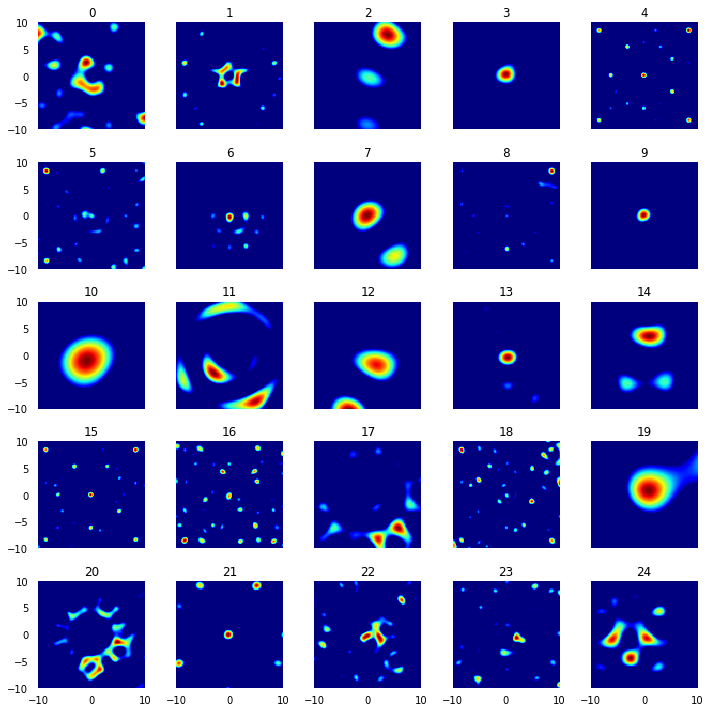

In [55]:
fig, axes = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(10,10))
axes_list = [item for sublist in axes for item in sublist] 

for idx in range(25):
    ax = axes_list.pop(0)
    ax.imshow(rd_pnorms[:,:,idx],cmap='jet',extent=(-size,size,-size,size))
    ax.set_title(idx)
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout()

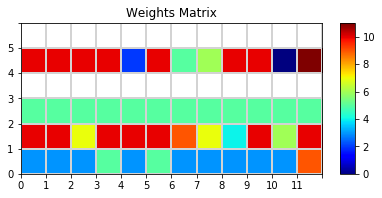

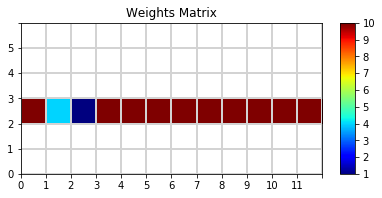

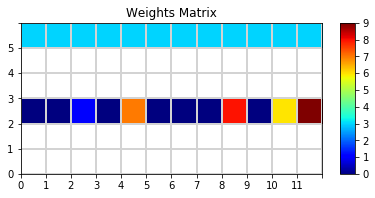

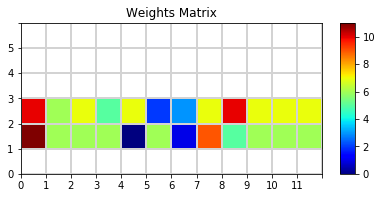

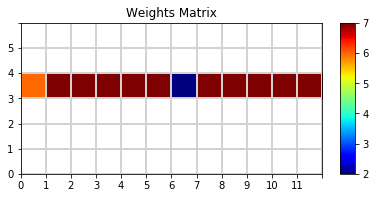

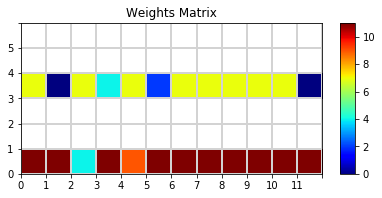

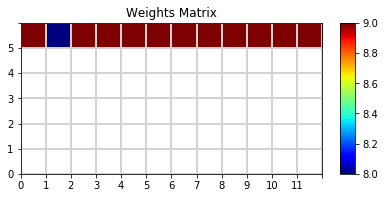

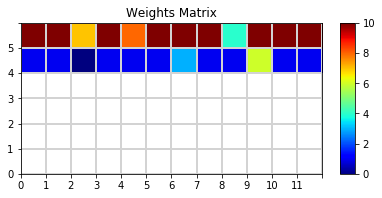

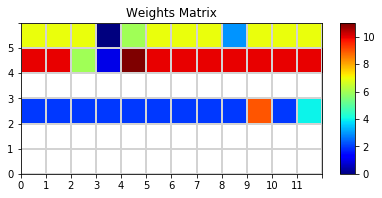

In [56]:
plot_weights(rd_pweights[:,:,0])
plot_weights(rd_pweights[:,:,7])
plot_weights(rd_pweights[:,:,8])
plot_weights(rd_pweights[:,:,12])
plot_weights(rd_pweights[:,:,13])
plot_weights(rd_pweights[:,:,14])
plot_weights(rd_pweights[:,:,15])
plot_weights(rd_pweights[:,:,16])
plot_weights(rd_pweights[:,:,23])

In [57]:
np.random.randint(1000,size=5)

array([196, 949, 881, 913, 906])

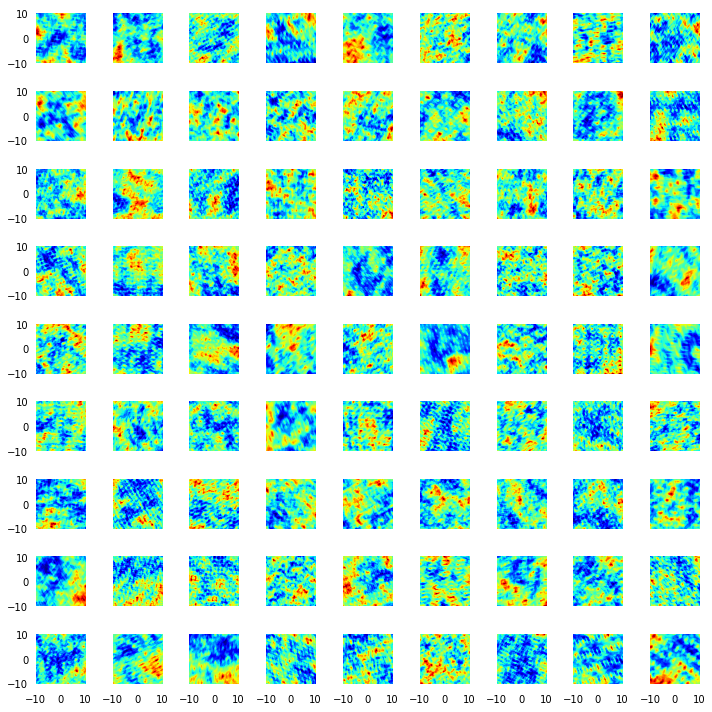

In [58]:
fig, axes = plt.subplots(nrows=9, ncols=9, sharex=True, sharey=True, figsize=(10,10))
axes_list = [item for sublist in axes for item in sublist] 

for idx in range(81):
    ax = axes_list.pop(0)
    rand_grids = np.random.randint(1000,size=30)
    place=np.zeros_like(rd_gnorms[:,:,0])
    for j, grid_idx in enumerate(rand_grids):
        place = place + rd_gnorms[:,:,grid_idx]
    ax.imshow(place,cmap='jet',extent=(-size,size,-size,size))
    #ax.set_title(idx)
    ax.tick_params(
        which='both',
        bottom='off',
        left='off',
        right='off',
        top='off'
    )
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# Now use the matplotlib .remove() method to 
# delete anything we didn't use
for ax in axes_list:
    ax.remove()

plt.tight_layout()

### Creating Grid Cells with Multiplication, not Addition

In [59]:
ringsize = 12
minrho = 0.14
rotation_angle = 0
rhos = minrho * (np.sqrt(3)**(np.arange(6)))
thetas = np.pi + rotation_angle + 2*np.pi*(np.arange(ringsize))/ringsize 
jitter = 0

VCOmult = [[],[],[],[],[],[]]
for row in range(6):
    for col in range(ringsize):
        VCOmult[row].append(RingOscillator(ringsize, rhos[row], thetas[col], jitter))

In [60]:
weights = np.full([6,12],np.nan)
weights[3,0] = 5
weights[3,4] = 5
weights[3,8] = 5

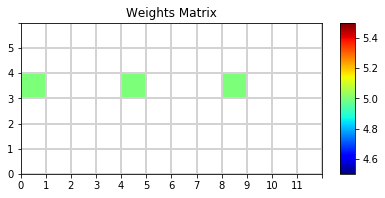

In [61]:
plot_weights(weights)

In [62]:
normt, prodt = theta_to_grid(VCOmult, weights, 20)

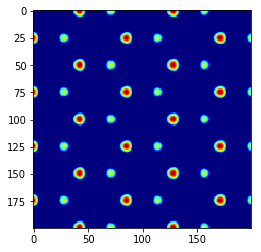

In [63]:
plt.imshow(normt,cmap='jet')

In [64]:
test =  VCOmult[5][0].cell_activity_3(1,xx, yy)
test2 = VCOmult[5][4].cell_activity_3(1,xx, yy)
test3 = VCOmult[5][8].cell_activity_3(1,xx, yy)
#test4 = VCOmult[5][2].cell_activity_3(1,xx, yy)
#test5 = VCOmult[5][6].cell_activity_3(1,xx, yy)
#test6 = VCOmult[5][10].cell_activity_3(1,xx, yy)
test4 = np.ones_like(test)
test5 = np.ones_like(test)
test6 = np.ones_like(test)

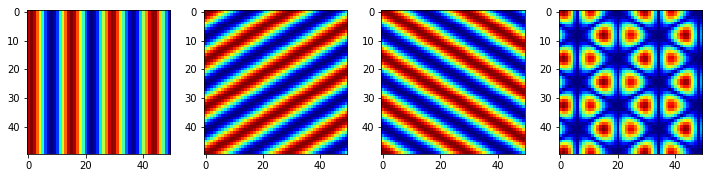

In [65]:
plt.figure(figsize=(10,5))
plt.subplot(141)
plt.imshow(np.real(test),cmap='jet')
#plt.colorbar()
plt.subplot(142)
plt.imshow(np.real(test2),cmap='jet')
#plt.colorbar()
plt.subplot(143)
plt.imshow(np.real(test3),cmap='jet')
#plt.colorbar()
plt.subplot(144)
plt.imshow(np.abs(test*test2*test3*test4*test5*test6),cmap='jet')
#plt.colorbar()
plt.tight_layout()

For some reason, cells 3, 7, and 11 in the rings have really odd products.